In [1]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
import torch
import sklearn

In [3]:
from pyqpanda import *

In [4]:
%matplotlib inline

# 1. Prepare Dadaset

In [5]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [6]:
train_path = './../data/DailyDelhiClimateTrain.csv'
test_path = './../data/DailyDelhiClimateTest.csv'

In [7]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [8]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

### 1.1.1 outlier detection for train

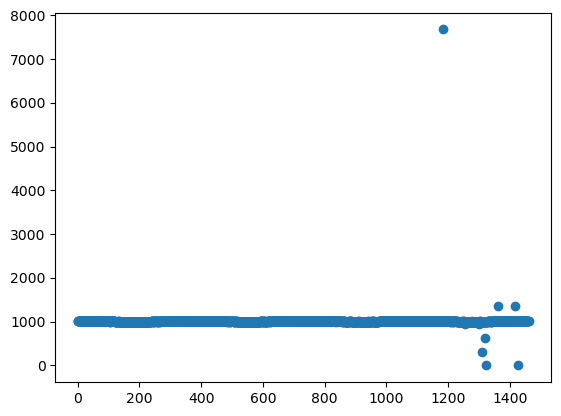

In [9]:
plt.scatter(range(len(train)), train["meanpressure"])

### - remove outliers 

In [10]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


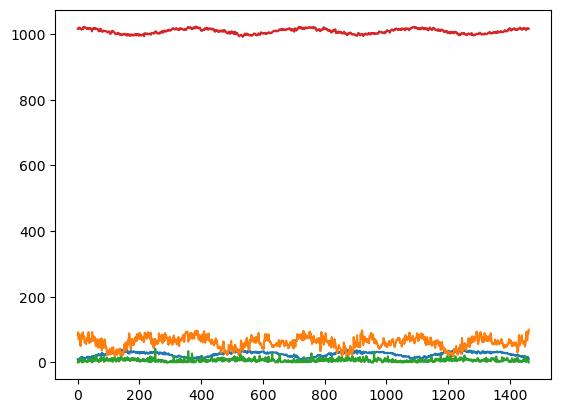

In [11]:
plt.plot(train)

In [12]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1008.247674,7.437992,991.375000,1001.625000,1008.563492,1014.875000,1023.000000


In [13]:
train[0:1]

,meantemp,humidity,wind_speed,meanpressure
0,10.0,84.5,0.0,1015.666667


### 1.1.2 outlier detection for test

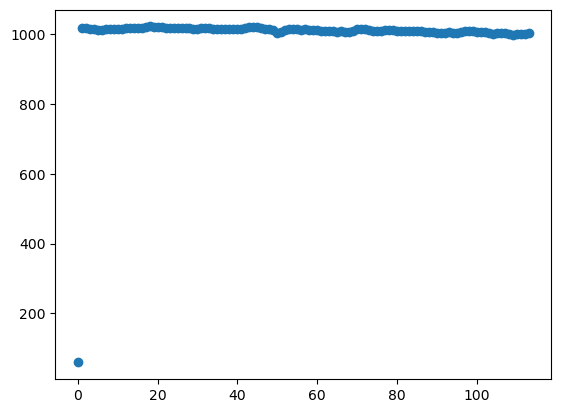

In [14]:
plt.scatter(range(len(test)), test["meanpressure"])

### - remove outliers 

In [15]:
test.iloc[0][3] = test.iloc[1][3]

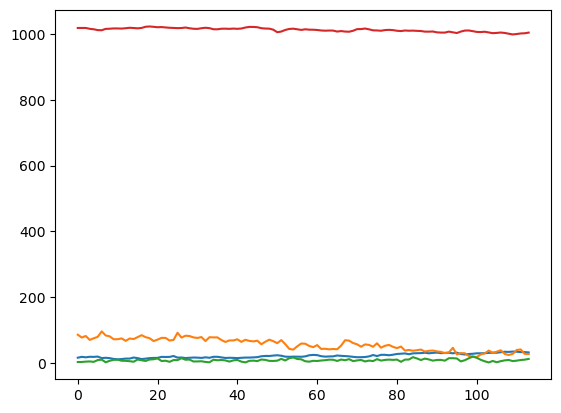

In [16]:
plt.plot(test)

## 1.2 Transfer data to LSTM representation

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [19]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [20]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [21]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

### - data loader

In [22]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)

In [23]:
print(f'size of train_data: {len(train_data)}')
print(f'size of test_data: {len(test_data)}')

size of train_data: 5832
size of test_data: 440


In [24]:
train_data[0]

(tensor([-0.6262, -0.4504, -0.6498,  1.7473, -0.6323, -0.4327, -0.6428,  1.7523,
         -0.6329, -0.4445, -0.6389,  1.7543]),
 tensor([-0.6293, -0.4814, -0.6469,  1.7508]))

In [25]:
test_data[0]

(tensor([-0.6067, -0.4426, -0.6376,  1.7437, -0.6006, -0.4629, -0.6372,  1.7437,
         -0.6039, -0.4520, -0.6346,  1.7438]),
 tensor([-0.6001, -0.4797, -0.6333,  1.7377]))

# 2. Quantum Enhanced LSTM

## 2.1 initiate quantum environment

In [26]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [27]:
# maximum qubits size
ctx = InitQMachine(5)

Init Quantum Machine with qubits:[5] / cbits:[0] Successfully


## 2.2 Quantum Layer

### - Tool Functions

In [28]:
def draw(prog, filename=''):
    dir_path = './images/'
    
    if filename != '':
        draw_qprog(prog, 'pic', filename=f'{dir_path}{filename}')

### 2.2.1 Quantum Layer Base

In [29]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [30]:
class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

In [31]:
def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

In [32]:
def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

### 2.2.2 Quantum Layer Design

In [33]:
dropout_lock = True

In [34]:
class QuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, degree = 1, n_layers = 1, ctx = None, dropout_rate = 0):
        super(QuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degree = degree
        self.dropout_rate = dropout_rate
        self.angles = Parameter(torch.rand(n_layers + 1, degree, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degree = self.degree
        
        # quantum gates - must use small case!
        identity = VariationalQuantumGate_I
        h = VariationalQuantumGate_H
        XGate = VariationalQuantumGate_X
        ry = VariationalQuantumGate_RY
        cz = VariationalQuantumGate_CZ
        u = [
            None,
            VariationalQuantumGate_U1,
            VariationalQuantumGate_U2,
            VariationalQuantumGate_U3
        ]
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # in order to use each qubits => when n_qubits < len(ctx.qubits)
        [ vqc.insert(identity(q[i])) for i in range(len(q)) ]
        
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi / 2)) ) for i in range(n) ]
        
    
        for i in range(n):
            vqc.insert( u[degree](q[i], *[ var(p[0][d][i]) for d in range(degree) ]) )
            if dropout_lock and np.random.rand() <= self.dropout_rate:
                vqc.insert( XGate(q[i]) )
        
        for layer in range(self.n_layers):
            for i in range(n - 1):
                if (not dropout_lock) or np.random.rand() > 0.0001:
                    vqc.insert(cz(q[i], q[i + 1]))
            if (not dropout_lock) or np.random.rand() > 0.0001:
                vqc.insert(cz(q[n - 1], q[0]))
            
            for i in range(n):
                vqc.insert( u[degree](q[i], *[ var(p[layer + 1][d][i]) for d in range(degree) ]) )
                if dropout_lock and np.random.rand() <= self.dropout_rate:
                    vqc.insert( XGate(q[i]) )
        
        return vqc

## 2.3 Quantum-LSTM

In [35]:
class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        self.dropout_rate = dropout_rate
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

In [36]:
def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

### 2.3.1 classical Quantum-LSTM

In [37]:
class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # Parameters: angles
        #  => Q * (n + 1) * degree
        
        # gates names:  qubits  layers  degree
        # input gate:     5       2       3
        # forget gate:    5       2       3
        # candidate:      5       2       3
        # output gate:    5       2       3
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.2 adjusted classical QLSTM

In [38]:
class AdjustedQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(AdjustedQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.3 peephole QLSTM

In [39]:
class PeepholeQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(PeepholeQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((c_t[0], x_t), dim = 1)
            
            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.4 Coupled Input and Forget gates QLSTM

In [40]:
class CIFGQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # coupled IF:     5       2       3
        # candidate:      4       2       3
        # output gate:    3       2       2
        
        # Coupled Input and Forget gate
        self.coupled_IF_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 30
        # candidate for cell state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 12
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(CIFGQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # coupled input and forget gate
            f_t = torch.sigmoid(self.coupled_IF_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + ((1 - f_t) * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.5 Recurrent Gate Units - QGRU

In [41]:
class QGRU(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # update gate:     5       1       3
        # candidate:       4       1       3
        # reset gate:      3       1       2
        
        # update gates
        self.update_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate for hidden state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # reset gates
        self.reset_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 1, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QGRU, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # update gates
            z_t = torch.sigmoid(self.update_circuit(v_t))
            # reset gates
            r_t = torch.sigmoid(self.reset_circuit(v_t))
        
            v_hat_t = torch.cat(((r_t * h_t)[0], x_t), dim = 1)
            # candidate for hidden state update
            g_t = torch.tanh(self.candidate_circuit(v_hat_t))
            h_t = (z_t * g_t) + (1 - z_t) * h_t 

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### - QLSTMs Map

In [42]:
QLSTMMap = {
    'classical': ('QLSTM', QLSTM),
    'adjusted': ('QLSTM(adjusted)', AdjustedQLSTM),
    'peephole': ('peephole QLSTM', PeepholeQLSTM),
    'CIFG': ('CIFG-QLSTM', CIFGQLSTM),
    'GRU': ('QGRU', QGRU)
}

## 2.4 Stacked QLSTM

In [43]:
from collections import OrderedDict

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super().__init__()
        
        label, qlstm = QLSTMMap.get(mode)
        self.qlstms = nn.Sequential(OrderedDict([
            (f'{label} {i + 1}', qlstm(input_size if i == 0 else hidden_size , hidden_size, ctx = ctx, dropout_rate = dropout_rate)) 
                for i in range(num_layers)
        ]))

    def forward(self, inputs, parameters = None):
        outputs = None
        
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
        
        return outputs, parameters

# 3. Quantum Model and Train

In [44]:
class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.mode = mode
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode, dropout_rate = dropout_rate)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [45]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50, early_stop = False):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    last_loss = 0.0
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        loss = train_loss / batch_size
        if early_stop and loss < 0.0005:
            break
            
        last_loss = loss
        
        print(f'Epoch {step + 1}/{epoch}: Loss: {loss}')
        losses.append(loss)
    
    return losses

## 3.2 Evaluate Model

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=test_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mape = mean_absolute_percentage_error(actuals, predicteds)
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae, mape])

## 3.3 Train Model

In [47]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [51]:
# learning rate:
# classical: 0.0035
# adjusted: 0.0028
# peephole: 0.0027
# CIFG: 0.004
# GRU: 0.0035

In [316]:
best_score = 0
best_model = None
count = 1
for dropout_rate in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05]:
    print('-' * 20)
    print('count:', count)
    print('selected hidden_size: ', hidden_size)
    print('selected num_layers: ', num_layers)
    print('selected dropout_rate: ', dropout_rate)
    count += 1
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
        num_layers = num_layers, ctx = ctx, mode='adjusted', dropout_rate=dropout_rate)
    optimizer = torch.optim.AdamW(qmodel.parameters(), lr = 0.0028)
    loss_func = nn.MSELoss()

    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 100)
    dropout_lock = False
    score = calculate_accuarcy(qmodel, X_test, y_test).numpy()
    if score > best_score:
        best_score = score
        best_model = qmodel
        best_parameters = {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate
        }
    print()

print("Best score: ", best_score)
print("Best parameters: ", best_parameters)

--------------------
count: 1
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.0001
Epoch 1/100: Loss: 1.020616590976715
Epoch 2/100: Loss: 0.9930036574602127
Epoch 3/100: Loss: 0.9349047243595123
Epoch 4/100: Loss: 0.9628809511661529
Epoch 5/100: Loss: 0.8814687311649323
Epoch 6/100: Loss: 0.8681190490722657
Epoch 7/100: Loss: 0.6939380809664726
Epoch 8/100: Loss: 0.7897430092096329
Epoch 9/100: Loss: 0.5949706584215164
Epoch 10/100: Loss: 0.4696167305111885
Epoch 11/100: Loss: 0.41586029082536696
Epoch 12/100: Loss: 0.49252458959817885
Epoch 13/100: Loss: 0.284439542144537
Epoch 14/100: Loss: 0.25995105169713495
Epoch 15/100: Loss: 0.31002686992287637
Epoch 16/100: Loss: 0.2176356490701437
Epoch 17/100: Loss: 0.24778842236846685
Epoch 18/100: Loss: 0.26818136414512994
Epoch 19/100: Loss: 0.20047192024067045
Epoch 20/100: Loss: 0.22452752105891705
Epoch 21/100: Loss: 0.163795168325305
Epoch 22/100: Loss: 0.12399341273121536
Epoch 23/100: Loss: 0.131715555675

Epoch 95/100: Loss: 0.0007536530307334033
Epoch 96/100: Loss: 0.010962650575675071
Epoch 97/100: Loss: 0.0016683553491020574
Epoch 98/100: Loss: 0.0004063686771587527
Epoch 99/100: Loss: 0.0009043138063134393
Epoch 100/100: Loss: 0.00101987408252171

--------------------
count: 3
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.0003
Epoch 1/100: Loss: 0.9093108475208282
Epoch 2/100: Loss: 1.0080645829439163
Epoch 3/100: Loss: 1.0248996436595916
Epoch 4/100: Loss: 0.974160012602806
Epoch 5/100: Loss: 0.9620782256126403
Epoch 6/100: Loss: 0.8862995356321335
Epoch 7/100: Loss: 0.83589988052845
Epoch 8/100: Loss: 0.7549990326166153
Epoch 9/100: Loss: 0.6821719765663147
Epoch 10/100: Loss: 0.6210481077432632
Epoch 11/100: Loss: 0.4907668475061655
Epoch 12/100: Loss: 0.5701426075771451
Epoch 13/100: Loss: 0.34619541829451916
Epoch 14/100: Loss: 0.2835132616572082
Epoch 15/100: Loss: 0.32242035334929825
Epoch 16/100: Loss: 0.2935792127624154
Epoch 17/100: Loss: 0.22

Epoch 91/100: Loss: 0.0004844422544920235
Epoch 92/100: Loss: 0.000717052419349784
Epoch 93/100: Loss: 0.0003517754000313289
Epoch 94/100: Loss: 0.0016994563360640314
Epoch 95/100: Loss: 0.0007244566741974268
Epoch 96/100: Loss: 0.0004593707770254696
Epoch 97/100: Loss: 0.0007438329099386465
Epoch 98/100: Loss: 0.0005542086124478374
Epoch 99/100: Loss: 0.14202243669060408
Epoch 100/100: Loss: 0.011440145480446518

--------------------
count: 5
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.0005
Epoch 1/100: Loss: 1.0006211757659913
Epoch 2/100: Loss: 0.9757197290658951
Epoch 3/100: Loss: 0.9537920117378235
Epoch 4/100: Loss: 0.9156303524971008
Epoch 5/100: Loss: 0.8739018201828003
Epoch 6/100: Loss: 0.8948944061994553
Epoch 7/100: Loss: 0.7903747081756591
Epoch 8/100: Loss: 0.7768402323126793
Epoch 9/100: Loss: 0.6895641312003136
Epoch 10/100: Loss: 0.6390313282608986
Epoch 11/100: Loss: 0.5956125259399414
Epoch 12/100: Loss: 0.563171063363552
Epoch 13/100:

Epoch 87/100: Loss: 0.0032339884019165765
Epoch 88/100: Loss: 0.0014322620427265065
Epoch 89/100: Loss: 0.000319269531610189
Epoch 90/100: Loss: 0.0005897683829971356
Epoch 91/100: Loss: 0.0004109814002731582
Epoch 92/100: Loss: 0.003830744202059577
Epoch 93/100: Loss: 0.0008313330539749586
Epoch 94/100: Loss: 0.002292811343977519
Epoch 95/100: Loss: 0.0005917891945500742
Epoch 96/100: Loss: 0.0002574886924776365
Epoch 97/100: Loss: 0.0256619460087677
Epoch 98/100: Loss: 0.003388916520634666
Epoch 99/100: Loss: 0.06455486939521507
Epoch 100/100: Loss: 0.005664212184638018

--------------------
count: 7
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.002
Epoch 1/100: Loss: 1.003561070561409
Epoch 2/100: Loss: 0.9971017807722091
Epoch 3/100: Loss: 0.980661290884018
Epoch 4/100: Loss: 0.9513360857963562
Epoch 5/100: Loss: 0.9414222836494446
Epoch 6/100: Loss: 0.9105058580636978
Epoch 7/100: Loss: 0.9250979661941529
Epoch 8/100: Loss: 0.823704668879509
Epoch 9/1

Epoch 85/100: Loss: 0.013749689666292397
Epoch 86/100: Loss: 0.001584439653379377
Epoch 87/100: Loss: 0.0012767679072567262
Epoch 88/100: Loss: 0.07947935712727486
Epoch 89/100: Loss: 0.006164943469957507
Epoch 90/100: Loss: 0.0037076558048283912
Epoch 91/100: Loss: 0.10687402663397734
Epoch 92/100: Loss: 0.019499001602525823
Epoch 93/100: Loss: 0.004983667522174074
Epoch 94/100: Loss: 0.00511281611470622
Epoch 95/100: Loss: 0.20262069514283212
Epoch 96/100: Loss: 0.011466324953653384
Epoch 97/100: Loss: 0.002286908017413225
Epoch 98/100: Loss: 0.028281562226766255
Epoch 99/100: Loss: 0.0022470493349828757
Epoch 100/100: Loss: 0.0021717541680118303

--------------------
count: 9
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.005
Epoch 1/100: Loss: 0.9819510996341705
Epoch 2/100: Loss: 0.9521757453680039
Epoch 3/100: Loss: 0.957593035697937
Epoch 4/100: Loss: 0.8894016742706299
Epoch 5/100: Loss: 0.8589480429887771
Epoch 6/100: Loss: 0.8064670473337173
Epoch

Epoch 85/100: Loss: 0.030516735347919165
Epoch 86/100: Loss: 0.26784821634646505
Epoch 87/100: Loss: 0.07994626101572067
Epoch 88/100: Loss: 0.22387084213551134
Epoch 89/100: Loss: 0.16426770771213342
Epoch 90/100: Loss: 0.01709851414489094
Epoch 91/100: Loss: 0.045731861170497726
Epoch 92/100: Loss: 0.05633261312032119
Epoch 93/100: Loss: 0.23794986918801442
Epoch 94/100: Loss: 0.10362581129229512
Epoch 95/100: Loss: 0.058783211396075785
Epoch 96/100: Loss: 0.04788602924672887
Epoch 97/100: Loss: 0.16384163916809485
Epoch 98/100: Loss: 0.2202635155641474
Epoch 99/100: Loss: 0.24781683105975388
Epoch 100/100: Loss: 0.04595508546335623

--------------------
count: 11
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.02
Epoch 1/100: Loss: 1.0276935607194901
Epoch 2/100: Loss: 0.9691277861595153
Epoch 3/100: Loss: 0.9887486457824707
Epoch 4/100: Loss: 0.9218626409769058
Epoch 5/100: Loss: 0.9065384358167649
Epoch 6/100: Loss: 0.8465867102146148
Epoch 7/100: Loss:

Epoch 86/100: Loss: 0.05996417670539813
Epoch 87/100: Loss: 0.08616315488470719
Epoch 88/100: Loss: 0.170330479653785
Epoch 89/100: Loss: 0.2485064195781888
Epoch 90/100: Loss: 0.24168613229994662
Epoch 91/100: Loss: 0.19778078931558413
Epoch 92/100: Loss: 0.1848982442432316
Epoch 93/100: Loss: 0.21681011715845672
Epoch 94/100: Loss: 0.21835389704210684
Epoch 95/100: Loss: 0.15535508749599103
Epoch 96/100: Loss: 0.28118575796252115
Epoch 97/100: Loss: 0.13641910559963435
Epoch 98/100: Loss: 0.051413549209246415
Epoch 99/100: Loss: 0.36827250467613337
Epoch 100/100: Loss: 0.19867527298920323

--------------------
count: 13
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.05
Epoch 1/100: Loss: 0.9707930684089661
Epoch 2/100: Loss: 1.037364211678505
Epoch 3/100: Loss: 0.9987148165702819
Epoch 4/100: Loss: 0.9331367075443268
Epoch 5/100: Loss: 0.9202987909317016
Epoch 6/100: Loss: 0.9137417197227478
Epoch 7/100: Loss: 0.9135418504476547
Epoch 8/100: Loss: 0.91789

In [317]:
best_score

array(0.9834725, dtype=float32)

In [69]:
epoch = 3
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    print(f'epoch: {i+1}')
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.0001)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 200, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

epoch: 1
Epoch 1/200: Loss: 0.9868188589811325
Epoch 2/200: Loss: 1.0125647217035294
Epoch 3/200: Loss: 0.9457164376974105
Epoch 4/200: Loss: 0.8697834551334381
Epoch 5/200: Loss: 0.7348213419318199
Epoch 6/200: Loss: 0.6267214313149452
Epoch 7/200: Loss: 0.45449291467666625
Epoch 8/200: Loss: 0.3983240325003862
Epoch 9/200: Loss: 0.3174945798702538
Epoch 10/200: Loss: 0.3549494012317155
Epoch 11/200: Loss: 0.30979732075938954
Epoch 12/200: Loss: 0.3228935573861236
Epoch 13/200: Loss: 0.37797070720334885
Epoch 14/200: Loss: 0.3718167812001411
Epoch 15/200: Loss: 0.29274921527467085
Epoch 16/200: Loss: 0.26274130411329677
Epoch 17/200: Loss: 0.16705625971080734
Epoch 18/200: Loss: 0.25706255732802674
Epoch 19/200: Loss: 0.2135205392667558
Epoch 20/200: Loss: 0.17028163152281195
Epoch 21/200: Loss: 0.20412920803792076
Epoch 22/200: Loss: 0.14051360040248256
Epoch 23/200: Loss: 0.16044981225859373
Epoch 24/200: Loss: 0.055135691017494534
Epoch 25/200: Loss: 0.05324099608696997
Epoch 26/20

In [71]:
# bit flip: 0.0001:
# mean acc:  98.70144781880315
# mean rmse:  8.998499912254603
# mean mse:  84.21460533432038
# mean mae:  6.730961054369843
# mean mape:  0.31541766542221233

In [65]:
epoch = 3
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    print(f'epoch: {i+1}')
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.001)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 200, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

epoch: 1
Epoch 1/200: Loss: 0.9763062924146653
Epoch 2/200: Loss: 0.9895176976919174
Epoch 3/200: Loss: 0.9484077841043472
Epoch 4/200: Loss: 0.8604175180196763
Epoch 5/200: Loss: 0.7591973394155502
Epoch 6/200: Loss: 0.6963816821575165
Epoch 7/200: Loss: 0.7108021378517151
Epoch 8/200: Loss: 0.6393304988741875
Epoch 9/200: Loss: 0.5231485664844513
Epoch 10/200: Loss: 0.4991500899195671
Epoch 11/200: Loss: 0.38845378868281843
Epoch 12/200: Loss: 0.5358808666467667
Epoch 13/200: Loss: 0.3585273828357458
Epoch 14/200: Loss: 0.3928357779979706
Epoch 15/200: Loss: 0.30684219747781755
Epoch 16/200: Loss: 0.1789113163948059
Epoch 17/200: Loss: 0.14999186992645264
Epoch 18/200: Loss: 0.113891232595779
Epoch 19/200: Loss: 0.06406706767738797
Epoch 20/200: Loss: 0.044361947855213656
Epoch 21/200: Loss: 0.06388493703125278
Epoch 22/200: Loss: 0.06619224241003394
Epoch 23/200: Loss: 0.024655774961865974
Epoch 24/200: Loss: 0.024523748537467326
Epoch 25/200: Loss: 0.012802976428065448
Epoch 26/200

Epoch 200/200: Loss: 0.0015348073349741754
time costs: 1467.3297390937805
[ 98.43841007  11.42376988 130.50251835   8.09440016   0.32236526]
epoch: 2
Epoch 1/200: Loss: 1.0587307035923004
Epoch 2/200: Loss: 0.9793840616941452
Epoch 3/200: Loss: 0.933184814453125
Epoch 4/200: Loss: 0.868699899315834
Epoch 5/200: Loss: 0.7988718897104263
Epoch 6/200: Loss: 0.6830669432878494
Epoch 7/200: Loss: 0.5185606583952904
Epoch 8/200: Loss: 0.38938108310103414
Epoch 9/200: Loss: 0.3248237922787666
Epoch 10/200: Loss: 0.2656081266701221
Epoch 11/200: Loss: 0.12043856382369995
Epoch 12/200: Loss: 0.1220509398728609
Epoch 13/200: Loss: 0.06492175930179656
Epoch 14/200: Loss: 0.022070422943215817
Epoch 15/200: Loss: 0.008753101085312664
Epoch 16/200: Loss: 0.002663731385109713
Epoch 17/200: Loss: 0.0015307767182093813
Epoch 18/200: Loss: 0.0044178016869409475
Epoch 19/200: Loss: 0.0022061723786464425
Epoch 20/200: Loss: 0.13882295932526176
Epoch 21/200: Loss: 0.03410091583209578
Epoch 22/200: Loss: 0.

In [66]:
# mean acc:  98.56704394376607
# mean rmse:  10.37245588109252
# mean mse:  108.26378559553125
# mean mae:  7.427634828077718
# mean mape:  0.41142231581887395

In [77]:
epoch = 3
acc, rmse, mse, mae, mape = 0, 0, 0, 0, 0
for i in range(epoch):
    print(f'epoch: {i+1}')
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.01)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.01)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 300, early_stop=True)
    end = time.time()

    print(f'time costs: {end - start}')

    dropout_lock = False
    results = calculate_accuarcy(qmodel, X_test, y_test)
    acc += results[0]
    rmse += results[1]
    mse += results[2]
    mae += results[3]
    mape += results[4]

    print(results)

print('mean acc: ', acc / epoch)
print('mean rmse: ', rmse / epoch)
print('mean mse: ', mse / epoch)
print('mean mae: ', mae / epoch)
print('mean mape: ', mape / epoch)

epoch: 1
Epoch 1/300: Loss: 0.9847398489713669
Epoch 2/300: Loss: 0.9214470773935318
Epoch 3/300: Loss: 1.0130189657211304
Epoch 4/300: Loss: 0.9448606848716736
Epoch 5/300: Loss: 0.7875354528427124
Epoch 6/300: Loss: 0.7457197319716216
Epoch 7/300: Loss: 0.7046803190372884
Epoch 8/300: Loss: 0.6913415605202318
Epoch 9/300: Loss: 0.8076891841366887
Epoch 10/300: Loss: 0.649018156528473
Epoch 11/300: Loss: 0.7153695546090603
Epoch 12/300: Loss: 0.4646258769091219
Epoch 13/300: Loss: 0.544297993183136
Epoch 14/300: Loss: 0.3097902270732448
Epoch 15/300: Loss: 0.4838627168908715
Epoch 16/300: Loss: 0.29736958066932856
Epoch 17/300: Loss: 0.24306108341552318
Epoch 18/300: Loss: 0.25858821771107615
Epoch 19/300: Loss: 0.26605725318659096
Epoch 20/300: Loss: 0.1409776580519974
Epoch 21/300: Loss: 0.3523655039258301
Epoch 22/300: Loss: 0.34562101897317915
Epoch 23/300: Loss: 0.23650215910747646
Epoch 24/300: Loss: 0.24182394952513278
Epoch 25/300: Loss: 0.31060716486535966
Epoch 26/300: Loss:

Epoch 205/300: Loss: 0.09970939865743275
Epoch 206/300: Loss: 0.09352160152047873
Epoch 207/300: Loss: 0.07363704434828833
Epoch 208/300: Loss: 0.023192874144297094
Epoch 209/300: Loss: 0.07692870856262743
Epoch 210/300: Loss: 0.059809833072358744
Epoch 211/300: Loss: 0.1111930045299232
Epoch 212/300: Loss: 0.1142167751211673
Epoch 213/300: Loss: 0.07252545813680626
Epoch 214/300: Loss: 0.047743178973905745
Epoch 215/300: Loss: 0.07742219914216548
Epoch 216/300: Loss: 0.13176158820278944
Epoch 217/300: Loss: 0.01935772243887186
Epoch 218/300: Loss: 0.0948199461447075
Epoch 219/300: Loss: 0.029620955302380025
Epoch 220/300: Loss: 0.07099430909147486
Epoch 221/300: Loss: 0.015286107949214056
Epoch 222/300: Loss: 0.08831334557035006
Epoch 223/300: Loss: 0.06807185101497452
Epoch 224/300: Loss: 0.0461234976304695
Epoch 225/300: Loss: 0.08560268283181358
Epoch 226/300: Loss: 0.022778589208610357
Epoch 227/300: Loss: 0.04910400054650381
Epoch 228/300: Loss: 0.10168655050802045
Epoch 229/300:

Epoch 105/300: Loss: 0.0104165171564091
Epoch 106/300: Loss: 0.015504091678303666
Epoch 107/300: Loss: 0.0040057771388092075
Epoch 108/300: Loss: 0.016016653060796672
Epoch 109/300: Loss: 0.08961240559292491
Epoch 110/300: Loss: 0.0838395120576024
Epoch 111/300: Loss: 0.061230543185956776
Epoch 112/300: Loss: 0.07948058084584772
Epoch 113/300: Loss: 0.013043773389654234
Epoch 114/300: Loss: 0.09864329040865413
Epoch 115/300: Loss: 0.035038440364587586
Epoch 116/300: Loss: 0.006256421768921427
Epoch 117/300: Loss: 0.03378706088551553
Epoch 118/300: Loss: 0.030408801068551837
Epoch 119/300: Loss: 0.0530658936011605
Epoch 120/300: Loss: 0.013409858077648096
Epoch 121/300: Loss: 0.04030334251292515
Epoch 122/300: Loss: 0.03778766209434252
Epoch 123/300: Loss: 0.09010033252416179
Epoch 124/300: Loss: 0.04036903016385622
Epoch 125/300: Loss: 0.07237287209136412
Epoch 126/300: Loss: 0.050332165008876474
Epoch 127/300: Loss: 0.012927330570528283
Epoch 128/300: Loss: 0.045355674880556765
Epoch 

Epoch 1/300: Loss: 1.0585434854030609
Epoch 2/300: Loss: 1.0101110517978669
Epoch 3/300: Loss: 0.8451853156089782
Epoch 4/300: Loss: 0.7309645488858223
Epoch 5/300: Loss: 0.7422696053981781
Epoch 6/300: Loss: 0.6308370903134346
Epoch 7/300: Loss: 0.4857326649129391
Epoch 8/300: Loss: 0.45482567697763443
Epoch 9/300: Loss: 0.35369353126734493
Epoch 10/300: Loss: 0.16535147833637892
Epoch 11/300: Loss: 0.3563191663473845
Epoch 12/300: Loss: 0.1389111268799752
Epoch 13/300: Loss: 0.18539929003454744
Epoch 14/300: Loss: 0.26831478137755765
Epoch 15/300: Loss: 0.1004091591166798
Epoch 16/300: Loss: 0.15467126093572006
Epoch 17/300: Loss: 0.2872797446558252
Epoch 18/300: Loss: 0.06462910140398889
Epoch 19/300: Loss: 0.2347694811061956
Epoch 20/300: Loss: 0.07042582677677274
Epoch 21/300: Loss: 0.06331647236365825
Epoch 22/300: Loss: 0.10648807599209249
Epoch 23/300: Loss: 0.09675321770482696
Epoch 24/300: Loss: 0.2639884436444845
Epoch 25/300: Loss: 0.07419970471237321
Epoch 26/300: Loss: 0.

Epoch 203/300: Loss: 0.029478796158218756
Epoch 204/300: Loss: 0.012094650673680008
Epoch 205/300: Loss: 0.02444909804253257
Epoch 206/300: Loss: 0.012889944209018723
Epoch 207/300: Loss: 0.019704242268926465
Epoch 208/300: Loss: 0.012006474580266513
Epoch 209/300: Loss: 0.08373045122716576
Epoch 210/300: Loss: 0.016197736246977002
Epoch 211/300: Loss: 0.01205107541900361
Epoch 212/300: Loss: 0.019595225060766098
Epoch 213/300: Loss: 0.06083401252399199
Epoch 214/300: Loss: 0.07383991060778498
Epoch 215/300: Loss: 0.044526799814775586
Epoch 216/300: Loss: 0.018539799191057683
Epoch 217/300: Loss: 0.0480470324633643
Epoch 218/300: Loss: 0.03873930699774064
Epoch 219/300: Loss: 0.013818850473035127
Epoch 220/300: Loss: 0.03397440513363108
Epoch 221/300: Loss: 0.07583280457183719
Epoch 222/300: Loss: 0.0543045374302892
Epoch 223/300: Loss: 0.07448053324478679
Epoch 224/300: Loss: 0.02043280963553116
Epoch 225/300: Loss: 0.0176658884214703
Epoch 226/300: Loss: 0.023102256387937815
Epoch 22

In [61]:
# mean acc:  96.91174787091217
# mean rmse:  20.19457283777217
# mean mse:  471.0036114346778
# mean mae:  16.007754719418312
# mean mape:  1.2276822370014242

In [50]:
dropout_lock = True
qmodel = QModel(input_size, hidden_size, num_output, 
                num_layers = num_layers, ctx = ctx, mode='classical', dropout_rate = 0.001)
optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0035)
loss_func = nn.MSELoss()

start = time.time()
losses = train_model(qmodel, train_data, batch_size=20,          
               loss_func = loss_func, optimizer = optimizer, epoch = 200, early_stop=True)
end = time.time()

print(f'time costs: {end - start}')

dropout_lock = False
results = calculate_accuarcy(qmodel, X_test, y_test)
print(f'results: {results}')

epoch: 1
Epoch 1/100: Loss: 1.0091356962919236
Epoch 2/100: Loss: 1.0195196866989136
Epoch 3/100: Loss: 0.9594021737575531
Epoch 4/100: Loss: 0.9657484143972397
Epoch 5/100: Loss: 0.9659673362970352
Epoch 6/100: Loss: 0.9192735850811005
Epoch 7/100: Loss: 0.8694848835468292
Epoch 8/100: Loss: 0.855216208100319
Epoch 9/100: Loss: 0.7518466204404831
Epoch 10/100: Loss: 0.7006594255566597
Epoch 11/100: Loss: 0.601554848253727
Epoch 12/100: Loss: 0.43977626860141755
Epoch 13/100: Loss: 0.6883462786674499
Epoch 14/100: Loss: 0.57449486926198
Epoch 15/100: Loss: 0.5523592203855514
Epoch 16/100: Loss: 0.512948502600193
Epoch 17/100: Loss: 0.45272375717759133
Epoch 18/100: Loss: 0.39852122832089665
Epoch 19/100: Loss: 0.41817463412880895
Epoch 20/100: Loss: 0.5864863362163305
Epoch 21/100: Loss: 0.5087891943752766
Epoch 22/100: Loss: 0.4719094388186932
Epoch 23/100: Loss: 0.35033201742917297
Epoch 24/100: Loss: 0.2838630314450711
Epoch 25/100: Loss: 0.3351413174532354
Epoch 26/100: Loss: 0.383

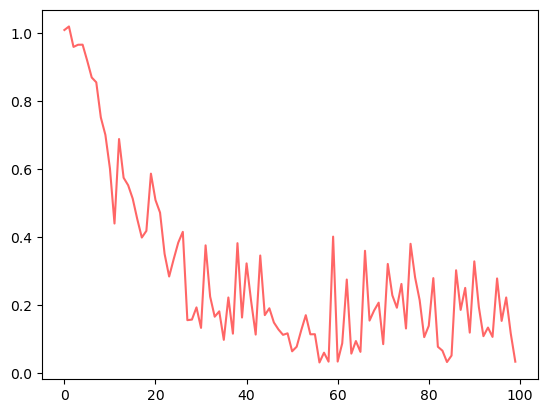

In [51]:
import matplotlib.pyplot as plt

plt.plot(losses, color="#FF6666")

In [52]:
dropout_lock = False
calculate_accuarcy(qmodel, X_test, y_test)

array([  93.35465848,   42.72097347, 1825.08157408,   34.44569701,
          3.03534378])

In [56]:
dropout_lock = False
calculate_accuarcy(qmodel, X_test, y_test)

array([98.61726888,  9.2365723 , 85.31426779,  7.16729712,  0.33737036])

In [57]:
# array([98.61726888,  9.2365723 , 85.31426779,  7.16729712,  0.33737036])

In [318]:
dropout_lock = False
calculate_accuarcy(best_model, X_test, y_test)

tensor(0.9835)

### - save the loss

In [282]:
with open('loss/bitflip/loss2.pkl', 'wb') as pkl_file:
    pickle.dump(losses, pkl_file)

In [281]:
average_accuracy = np.mean([
    0.9847, 0.9807, 0.9830, 0.9833, 0.9859
])
average_accuracy

0.9835200000000001

### - describe trained model

In [381]:
qmodel

QModel(
  (qlstm): StackedQLSTM(
    (qlstms): Sequential(
      (QGRU 1): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=4, bias=True)
          (qout): Linear(in_features=4, out_features=32, bias=True)
        )
        (reset_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=3, bias=True)
          (qout): Linear(in_features=3, out_features=32, bias=True)
        )
      )
      (QGRU 2): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=4, bias=True)
          (qout): Linear(in_features=

In [379]:
trainable = 0
for p in qmodel.parameters():
    if p.requires_grad:
        trainable += p.numel()
print(f'total parameters: {trainable}')

qlstm = QLSTMMap.get(qmodel.mode)[1]
print(f'quantum paramers: {qlstm(1, 1, ctx = ctx).qparameters_size}')

total parameters: 2544
quantum paramers: 66


### - Save the Model

In [320]:
# save the model
# 0.9835
torch.save(best_model.state_dict(), "model/bit_flip_adjusted.pt")

In [72]:
results = []

for i in range(0, len(X_test), features_size):
    input_data = X_test[i:i+1]
    result = qmodel(input_data)
    result = test_scaler.inverse_transform(result.data)
    
    results.append(result[0])

test1 = pd.DataFrame(test, columns=('meantemp',))
test2 = pd.DataFrame(test, columns=('humidity',))
test3 = pd.DataFrame(test, columns=('wind_speed',))
test4 = pd.DataFrame(test, columns=('meanpressure',))
results = pd.DataFrame(results)
results.columns = ('meantemp', 'humidity', 'wind_speed', 'meanpressure')
result1 = pd.DataFrame(results, columns=('meantemp', 'humidity', 'wind_speed'))
result2 = pd.DataFrame(results, columns=('meanpressure',))

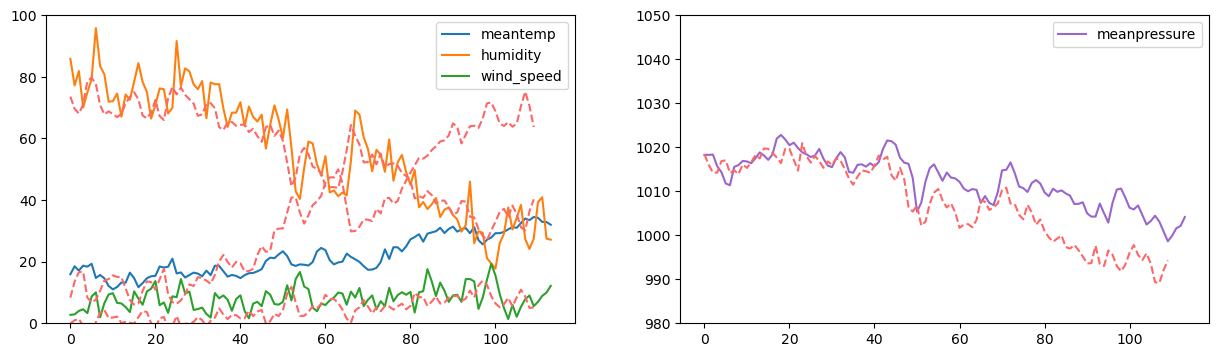

In [73]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(test1, label="meantemp")
plt.plot(test2, label="humidity")
plt.plot(test3, label="wind_speed")

# plt.subplot(1,2,2)
plt.ylim(0, 100)
plt.plot(result1, color="#FF6666", linestyle="--")
plt.legend()

# plt.subplot(1,2,1)
plt.subplot(1,2,2)
plt.plot(test4, label="meanpressure", color="#9966CC")
plt.ylim(980, 1050)
plt.plot(result2, color="#FF6666", linestyle='--')

plt.legend()